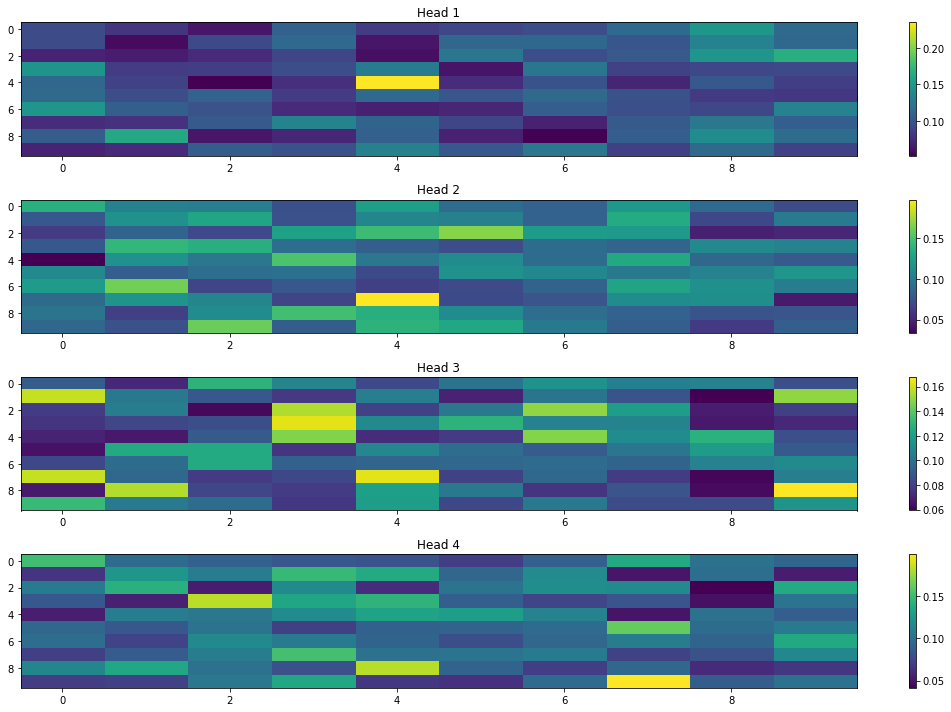

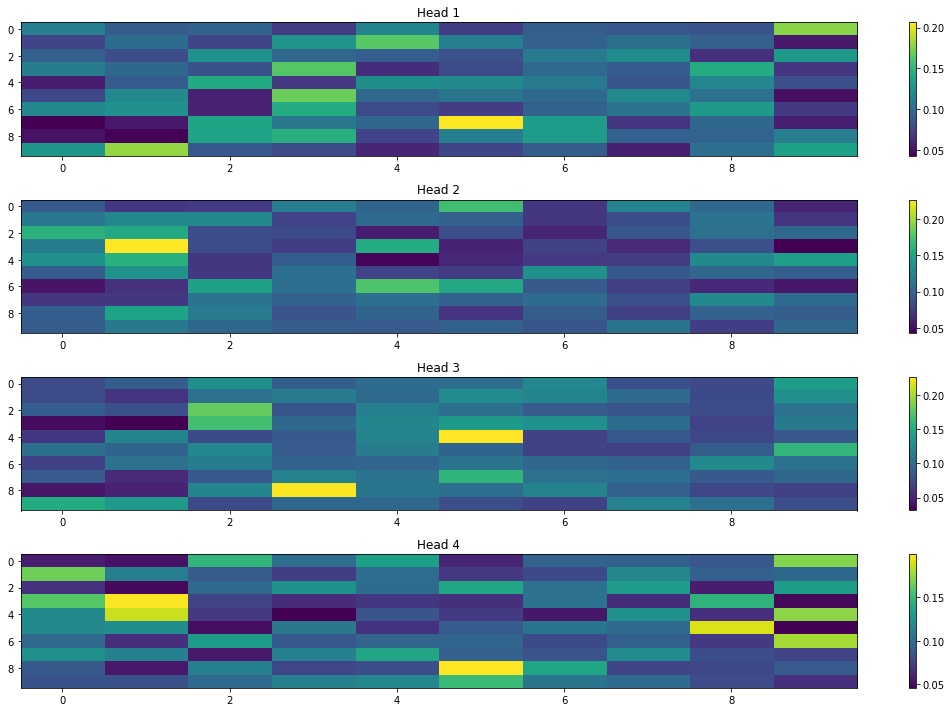

Output shape: torch.Size([1, 10, 64])


In [7]:
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

class MultiHeadSelfAttention(torch.nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == embed_dim, "embed_dim must be divisible by num_heads"

        self.linear_q = torch.nn.Linear(embed_dim, embed_dim)
        self.linear_k = torch.nn.Linear(embed_dim, embed_dim)
        self.linear_v = torch.nn.Linear(embed_dim, embed_dim)
        self.final_linear = torch.nn.Linear(embed_dim, embed_dim)
    
    def forward(self, x):
        batch_size, seq_length, _ = x.size()
        
        Q = self.linear_q(x).view(batch_size, seq_length, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        K = self.linear_k(x).view(batch_size, seq_length, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        V = self.linear_v(x).view(batch_size, seq_length, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        
        scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32))
        attention_weights = F.softmax(scores, dim=-1)
        attention_output = torch.matmul(attention_weights, V).transpose(1, 2).contiguous().view(batch_size, seq_length, self.embed_dim)
        
        output = self.final_linear(attention_output)
        return output, attention_weights

class MultiQueryAttention(torch.nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == embed_dim, "embed_dim must be divisible by num_heads"

        self.linear_q = torch.nn.Linear(embed_dim, embed_dim)
        self.linear_k = torch.nn.Linear(embed_dim, self.head_dim)
        self.linear_v = torch.nn.Linear(embed_dim, self.head_dim)
        self.final_linear = torch.nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        batch_size, seq_length, _ = x.size()
        
        Q = self.linear_q(x).view(batch_size, seq_length, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        K = self.linear_k(x).view(batch_size, seq_length, 1, self.head_dim).permute(0, 2, 1, 3)
        V = self.linear_v(x).view(batch_size, seq_length, 1, self.head_dim).permute(0, 2, 1, 3)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32))
        attention_weights = F.softmax(scores, dim=-1)        
        attention_output = torch.matmul(attention_weights, V).transpose(1, 2).contiguous().view(batch_size, seq_length, self.embed_dim)
        
        output = self.final_linear(attention_output)
        return output, attention_weights
    
class GroupedQueryAttention(torch.nn.Module):
    def __init__(self, embed_dim, num_queries, num_kv, query_per_group, kv_per_group):
        super(GroupedQueryAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_queries = num_queries
        self.num_kv = num_kv
        self.query_per_group = query_per_group
        self.kv_per_group = kv_per_group
        self.num_groups = num_queries // query_per_group
        
        assert num_queries % query_per_group == 0, "Total number of queries must be divisible by queries per group"
        assert num_kv % kv_per_group == 0, "Total number of keys/values must be divisible by keys/values per group"
        
        self.head_dim = embed_dim // num_queries
        
        self.linear_q = nn.Linear(embed_dim, num_queries * self.head_dim)
        self.linear_k = nn.Linear(embed_dim, num_kv * self.head_dim)
        self.linear_v = nn.Linear(embed_dim, num_kv * self.head_dim)
        
        self.wo = nn.Linear(num_queries * self.head_dim, embed_dim)
        
    def forward(self, x):
        batch_size, seq_length, _ = x.shape
        
        queries = self.linear_q(x)
        keys = self.linear_k(x)
        values = self.linear_v(x)

        queries = queries.view(batch_size, seq_length, self.num_groups, self.query_per_group, self.head_dim)
        keys = keys.view(batch_size, seq_length, self.num_groups, self.kv_per_group, self.head_dim)
        values = values.view(batch_size, seq_length, self.num_groups, self.kv_per_group, self.head_dim)
        
        output = torch.zeros_like(queries)
        
        for i in range(self.num_groups):
            q = queries[:, :, i, :, :].reshape(batch_size, seq_length, -1)
            k = keys[:, :, i, :, :].reshape(batch_size, seq_length, -1)
            v = values[:, :, i, :, :].reshape(batch_size, seq_length, -1)
            
            attn_scores = torch.matmul(q, k.transpose(-2, -1)) / (self.head_dim ** 0.5)
            attn_probs = F.softmax(attn_scores, dim=-1)
            attn_output = torch.matmul(attn_probs, v)
            
            output[:, :, i, :, :] = attn_output.view(batch_size, seq_length, self.query_per_group, self.head_dim)
        
        output = output.reshape(batch_size, seq_length, -1)
        output = self.wo(output)
        
        return output
    
def visualize_attention(attention_weights, num_heads):

    batch_size = attention_weights.size(0)
    for b in range(batch_size):
        plt.figure(figsize=(15, 10))
        for head in range(num_heads):
            plt.subplot(num_heads, 1, head + 1)
            plt.imshow(attention_weights[b, head].detach(), cmap='viridis', aspect='auto')
            plt.colorbar()
            plt.title(f'Head {head+1}')
        plt.tight_layout()
        plt.show()

dim = 64
num_heads = 4
num_groups = 2
num_queries = 8  
num_kv = 8     
query_per_group = 2  
kv_per_group = 2     
x = torch.randn(1, 10, dim)

msa = MultiHeadSelfAttention(embed_dim=dim, num_heads=num_heads)
output_msa, weights_msa = msa(x)
visualize_attention(weights_msa, num_heads=num_heads)

mqa = MultiQueryAttention(embed_dim=dim, num_heads=num_heads)
output_mqa, weights_mqa = mqa(x)
visualize_attention(weights_mqa, num_heads=num_heads)


gqa = GroupedQueryAttention(dim, num_queries, num_kv, query_per_group, kv_per_group)
output = gqa(x)
print("Output shape:", output.shape)